In [1]:
# pip install urllib
# pip install m3u8
# pip install streamlink
from datetime import datetime, timedelta, timezone
import urllib
import m3u8
import streamlink
import cv2 #openCV
import time
import numpy as np
import matplotlib.pyplot as plt

import pafy #for youtube streaming, requires youtube-dl



# Primary code for getting a youtube file

## IMPORTANT!
This version was working great.  It smoothly pulls the stream and splices it together.  Then something changed with YouTube (or I was blocked?) and no longer works.  

__Update__ After much effort, it seems like passing in a pafy URL fixes the issue and this does indeed work.  

In [6]:
videoURL = "https://www.youtube.com/watch?v=DoUOrTJbIu4" #Jackson hole town square, live stream

video = pafy.new(videoURL)

#only working on this specific video, lets confirm
assert ("Jackson Wyoming Town Square Live Webcam" in video.title) 

best = video.getbest(preftype="mp4")  #Get best resolution stream available
medVid = video.streams[2]

#See all stream qualitys
print(video.streams)

[normal:mp4@256x144, normal:mp4@426x240, normal:mp4@640x360, normal:mp4@854x480, normal:mp4@1280x720, normal:mp4@1920x1080]


In [10]:
#Ref: https://stackoverflow.com/questions/55631634/recording-youtube-live-stream-to-file-in-python
def get_stream(url):
    """
    Get upload chunk url
    input: youtube URL
    output: m3u8 object segment
    """
    
    #Try this line tries number of times, if it doesn't work, 
    # then show the exception on the last attempt
    # Credit, theherk, https://stackoverflow.com/questions/2083987/how-to-retry-after-exception
    tries = 10
    for i in range(tries):
        try:
            streams = streamlink.streams(url)
        except:
            if i < tries - 1: # i is zero indexed
                print(f"Attempt {i+1} of {tries}")
                time.sleep(0.1) #Wait half a second
                continue
            else:
                raise
        break
    #print(f"Stream choices: {streams.keys()})
    stream_url = streams["best"] #Alternate, use "best"

    m3u8_obj = m3u8.load(stream_url.args['url'])
    return m3u8_obj.segments[0] #Parsed stream


def dl_stream(url, filename, chunks):
    """
    Download each chunk to file
    input: url, filename, and number of chunks (int)
    output: saves file at filename location
    returns none.
    """
    pre_time_stamp = datetime(1, 1, 1, 0, 0, tzinfo=timezone.utc)

    
    #Repeat for each chunk
    #Needs to be in chunks beceause 
    #  1) it's live and 
    #  2) it won't let you leave the stream open forever
    i=1
    while i <= chunks:
       
        #Open stream
        stream_segment = get_stream(url)
        
        #Get current time on video
        cur_time_stamp = stream_segment.program_date_time
        #Only get next time step, wait if it's not new yet
        if cur_time_stamp <= pre_time_stamp:
            #Don't increment counter until we have a new chunk
            print("NO   pre: ",pre_time_stamp, "curr:",cur_time_stamp)
            time.sleep(0.5) #Wait half a sec
            pass
        else:
            print("YES: pre: ",pre_time_stamp, "curr:",cur_time_stamp)
            print(f'#{i} at time {cur_time_stamp}')
            #Open file for writing stream
            file = open(filename, 'ab+') #ab+ means keep adding to file
            #Write stream to file
            with urllib.request.urlopen(stream_segment.uri) as response:
                html = response.read()
                file.write(html)
                
            #Update time stamp
            pre_time_stamp = cur_time_stamp
            time.sleep(stream_segment.duration) #Wait duration time - 1

            i += 1 #only increment if we got a new chunk

    return None

def openCVProcessing(saved_video_file):
    '''View saved video with openCV
    Add your other steps here'''
    capture = cv2.VideoCapture(saved_video_file)

    while capture.isOpened():
        grabbed, frame = capture.read()  #read in single frame
        if grabbed == False:
            break

        #openCV processing goes here
        #
        
        cv2.imshow('frame',frame)  #Show the frame
        
        #Shown in a new window, To exit, push q on the keyboard
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break

    capture.release()
    cv2.destroyAllWindows()  #close the windows automatically

#Do the work    
tempFile = "no_cars_test.ts"  #files are format ts, open cv can view them
videoURL = "https://youtu.be/DoUOrTJbIu4" #Jackson hole town square, live stream

dl_stream(medVid.url, tempFile, 1)


YES: pre:  0001-01-01 00:00:00+00:00 curr: 2021-05-28 06:07:08.420000+00:00
#1 at time 2021-05-28 06:07:08.420000+00:00


In [5]:
medVid.url

'https://r1---sn-q4fl6nss.googlevideo.com/videoplayback?expire=1622203485&ei=_YewYJaqBpmCir4P6oWViAw&ip=75.60.121.193&id=o-AApYAljzhJjsPE-EOY1RJZOuOdAGdXaqTeLF2kedI_oD&itag=18&source=youtube&requiressl=yes&mh=6G&mm=31%2C29&mn=sn-q4fl6nss%2Csn-q4flrner&ms=au%2Crdu&mv=m&mvi=1&pl=20&initcwndbps=1508750&vprv=1&mime=video%2Fmp4&ns=uitTBpOXz2-wLpvX-UqizxAF&gir=yes&clen=125542291&ratebypass=yes&dur=1538.693&lmt=1585343465402181&mt=1622181191&fvip=1&fexp=24001373%2C24007246&c=WEB&txp=5431432&n=955Q2JsLixwlhpm6lk&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cvprv%2Cmime%2Cns%2Cgir%2Cclen%2Cratebypass%2Cdur%2Clmt&sig=AOq0QJ8wRgIhAOBlx0iWtz0HI7K_mKz2amKYd5ZXfjiYJXgep-QNe8D8AiEA8QQvN6RT5YI2ZBFlrKJdzp0pidlh-y8wvLOvabgPldY%3D&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpl%2Cinitcwndbps&lsig=AG3C_xAwRQIhAIui8H3I8oOd06UPnN-rcGftj6dkC4ehkle69WqrT303AiAei4kTCU50K7IaxgmPBSScfv5TWXufKiyFm0Kxa3GjVA%3D%3D'

In [11]:
#Process the newly made file
openCVProcessing(tempFile)

NameError: name 'pre_time_stamp' is not defined

In [9]:
#Process newly saved video testing new things
def openCVProcessing(saved_video_file):
    #View saved video with openCV
    capture = cv2.VideoCapture(saved_video_file)

    while capture.isOpened():
        grabbed, frame = capture.read()  #read in single frame
        if grabbed == False:
            break

        #openCV processing goes here
        
        
        cv2.imshow('frame',frame)  #Show the frame
        
        #Shown in a new window, To exit, push q on the keyboard
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break

    capture.release()
    cv2.destroyAllWindows()  #close the windows automatically


In [46]:
videoURL = "https://www.youtube.com/watch?v=DoUOrTJbIu4"
stream_segment = get_stream(videoURL)

# All in memory, no file downloads, prep for streamlit

In [12]:
videoURL = "https://www.youtube.com/watch?v=DoUOrTJbIu4" #Jackson hole town square, live stream

video = pafy.new(videoURL)

#only working on this specific video, lets confirm
assert ("Jackson Wyoming Town Square Live Webcam" in video.title) 

best = video.getbest(preftype="mp4")  #Get best resolution stream available
medVid = video.streams[2]

#See all stream qualitys
print(video.streams)

[normal:mp4@256x144, normal:mp4@426x240, normal:mp4@640x360, normal:mp4@854x480, normal:mp4@1280x720, normal:mp4@1920x1080]


In [33]:
#Ref: https://stackoverflow.com/questions/55631634/recording-youtube-live-stream-to-file-in-python
def get_stream(url):
    """
    Get upload chunk url
    input: youtube URL
    output: m3u8 object segment
    """
    
    #Try this line tries number of times, if it doesn't work, 
    # then show the exception on the last attempt
    # Credit, theherk, https://stackoverflow.com/questions/2083987/how-to-retry-after-exception
    tries = 10
    for i in range(tries):
        try:
            streams = streamlink.streams(url)
        except:
            if i < tries - 1: # i is zero indexed
                print(f"Attempt {i+1} of {tries}")
                time.sleep(0.1) #Wait half a second
                continue
            else:
                raise
        break
    #print(f"Stream choices: {streams.keys()})
    stream_url = streams["best"] #Alternate, use "best"

    m3u8_obj = m3u8.load(stream_url.args['url'])
    return m3u8_obj.segments[0] #Parsed stream


def stitch_streams(url, filename, chunks):
    """
    Download each chunk to file
    input: url, filename, and number of chunks (int)
    output: saves file at filename location
    returns none.
    """
    pre_time_stamp = datetime(1, 1, 1, 0, 0, tzinfo=timezone.utc)

    
    #Repeat for each chunk
    #Needs to be in chunks beceause 
    #  1) it's live and 
    #  2) it won't let you leave the stream open forever
    i=1
    while i <= chunks:
       
        #Open stream
        stream_segment = get_stream(url)
        
        #Get current time on video
        cur_time_stamp = stream_segment.program_date_time
        #Only get next time step, wait if it's not new yet
        if cur_time_stamp <= pre_time_stamp:
            #Don't increment counter until we have a new chunk
            print("NO   pre: ",pre_time_stamp, "curr:",cur_time_stamp)
            time.sleep(0.5) #Wait half a sec
            pass
        else:
            print("YES: pre: ",pre_time_stamp, "curr:",cur_time_stamp)
            print(f'#{i} at time {cur_time_stamp}')
            #Open file for writing stream
            file = open(filename, 'ab+') #ab+ means keep adding to file
            #Write stream to file
            with urllib.request.urlopen(stream_segment.uri) as response:
                html = response.read()
                file.write(html)
                
            #Update time stamp
            pre_time_stamp = cur_time_stamp
            time.sleep(stream_segment.duration) #Wait duration time - 1

            i += 1 #only increment if we got a new chunk

    return None

def openCVProcessing(saved_video_file):
    '''View saved video with openCV
    Add your other steps here'''
    capture = cv2.VideoCapture(saved_video_file)
    i=0
    while capture.isOpened():
        grabbed, frame = capture.read()  #read in single frame
        if grabbed == False:
            break

        #openCV processing goes here
        #
        
        cv2.imshow('frame',frame)  #Show the frame
        i +=1
        
        #Shown in a new window, To exit, push q on the keyboard
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    capture.release()
    cv2.destroyAllWindows()  #close the windows automatically
    return i



In [ ]:
#Do the work    
videoURL = "https://youtu.be/DoUOrTJbIu4" #Jackson hole town square, live stream

stitch_streams(medVid.url, 1)


In [8]:
#Sandbox
stream_segment = get_stream(medVid.url)
        
#Open file for writing stream
file = open("TEMP.TS", 'ab+') #ab+ means keep adding to file
#Write stream to file
with urllib.request.urlopen(stream_segment.uri) as response:
    html = response.read()
    file.write(html)



In [68]:
#Cant decode video streams
stream_segment = get_stream(medVid.url)
url = stream_segment.uri
resp = urllib.request.urlopen(url)
video = np.asarray(bytearray(resp.read()), dtype="uint8")
videoDecode = cv2.imdecode(video, cv2.IMREAD_COLOR)
# return the image

In [110]:
# no easy relation with read in byte stream and frame number...
stream_segment = get_stream(medVid.url)
url = stream_segment.uri

frames = openCVProcessing(url)
vid = urllib.request.urlopen(url).read()
vid_bytes = np.asarray(bytearray(vid), dtype="uint8")
print(vid_bytes.shape[0] , frames)
key.append((vid_bytes.shape[0] , frames))

210936 134


In [165]:
def frame_count(video_path, manual=False):
    """frame_count - get how many frames are in a video
    video_path - path to video
    manual - True or False, manual method is much more accurate but slow"""
    #Credit: https://stackoverflow.com/questions/25359288/
    #        how-to-know-total-number-of-frame-in-a-file-with-cv2-in-python
    # answer from: nanthancy 
    def manual_count(handler):
        frames = 0
        while True:
            status, frame = handler.read()
            if not status:
                break
            frames += 1
        return frames 

    cap = cv2.VideoCapture(video_path)
    # Slow, inefficient but 100% accurate method 
    if manual:
        frames = manual_count(cap)
    # Fast, efficient but inaccurate method
    else:
        try:
            frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        except:
            frames = manual_count(cap)
    cap.release()
    return frames

In [ ]:
#We can get multiple segments and look at duration though
#playlist = m3u8.load(medVid.url)  # this could also be an absolute filename
#print(playlist.segments)
#print(playlist.target_duration)
playlist.segments[2].duration

In [167]:
for i in playlist.segments:
    frames = frame_count(i.uri, manual=True)
    print(frames)

137
147
147


KeyboardInterrupt: 

In [29]:
def getVideoFrames(url, n_frames):
    '''getVideoFrames(url = string, n_frames= int)
    returns array of images.
    Runs once for each segment, 100-147 frames at once.
    Youtube segments don't cleanly exit from openCV, so I am instead chopping them off a little bit
    returns final strung together list of images.'''
    
    #load a list of current segments for live stream
    playlist = m3u8.load(url)
    
    #will hold all frames at the end
    frame_array=[]

    #Loop through all segments
    for i in playlist.segments:
        
        capture = cv2.VideoCapture(i.uri) 
    
        #go through every frame in segment
        for i in range(n_frames):  
            grabbed, frame = capture.read()  #read in single frame
            if grabbed == False:
                break

            cv2.imshow('frame',frame)  #Show the frame
            i +=1

            #Shown in a new window, To exit, push q on the keyboard
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            #Save to array for output
            #frame_array.append(frame)

    capture.release()

    return frame_array

In [ ]:
#This is the magic answer, which is surprisingly close to my first answer using only pafy.
frames_all = getVideoFrames(medVid.url, 110)
openCVProcessing(frames_all)
del frames_all  #save memory


In [48]:
#temp
assert type(1) == "int"

AssertionError: 

In [ ]:
frame_duration = []
#turns out number of frames is not perfectly correlated with duration :(
for i in range(5):
    # get new list of segments, may overlap with other previous
    playlist = m3u8.load(medVid.url)  # this could also be an absolute filename
    for i in playlist.segments:
        frames = frame_count(i.uri, manual=True)
        frame_duration.append([frames, i.duration])
        print([frames, i.duration])

[136, 5.0]
[135, 5.0]
[147, 4.999]
[132, 5.0]
[147, 5.0]
[147, 5.0]
[147, 5.0]
[128, 5.0]
[137, 5.0]
[147, 5.0]
[132, 5.0]
[147, 4.999]
[147, 5.0]
[147, 5.0]
[132, 5.0]
[142, 5.0]
[147, 5.0]
[147, 5.0]
[147, 5.0]
[147, 4.999]
[147, 5.0]


In [ ]:
x= [frame for frame, sec in frame_duration]
y= [sec for frame, sec in frame_duration]

plt.scatter(x,y)

In [147]:
fps = [frame/sec for frame, sec in frame_duration]
print(fps)
#fps is not constant/duration is not accurate!

[29.4, 29.4, 26.805361072214446, 29.4, 29.4, 29.4, 29.4]


In [109]:
key = []

for i in range (1):
    #stream_segment = get_stream(medVid.url)
    url = stream_segment.uri

    frames = openCVProcessing(url)
    vid = urllib.request.urlopen(url).read()
    vid_bytes = np.asarray(bytearray(vid), dtype="uint8")
    print(vid_bytes.shape[0] , frames)
    key.append((vid_bytes.shape[0] , frames))


URLError: <urlopen error timed out>

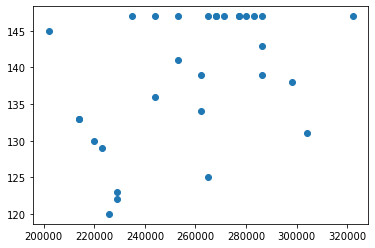

In [107]:

x = [key[i][0][0] for i in range(len(key))]
y = [key[i][1] for i in range(len(key))]

plt.scatter(x,y)

# Attempt to combine streaming and working into one!

In [7]:
#Ref: https://stackoverflow.com/questions/55631634/recording-youtube-live-stream-to-file-in-python
def get_stream(url):
    """
    Get upload chunk url
    input: youtube URL
    output: m3u8 object segment
    """
    #Get stream
    streams = streamlink.streams(url)
    stream_url = streams["360p"] #Alternate, use "best"

    m3u8_obj = m3u8.load(stream_url.args['url'])
    return m3u8_obj.segments[0] #Parsed stream

def openCVProcessing(saved_video_file):
    '''View saved video with openCV
    Add your other steps here'''
    capture = cv2.VideoCapture(saved_video_file)

    while capture.isOpened():
        grabbed, frame = capture.read()  #read in single frame
        if grabbed == False:
            break

        #openCV processing goes here
        #
        
        cv2.imshow('frame',frame)  #Show the frame
        
        #Shown in a new window, To exit, push q on the keyboard
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break

    capture.release()
    cv2.destroyAllWindows()  #close the windows automatically

def dl_stream(url, filename, chunks):
    """
    Download each chunk to file
    input: url, filename, and number of chunks (int)
    output: saves file at filename location
    returns none.
    """
    pre_time_stamp = 0
    
    #Repeat for each chunk
    #Needs to be in chunks beceause 
    #  1) it's live and 
    #  2) it won't let you leave the stream open forever
    i=1
    while i <= chunks:
       
        #Open stream
        stream_segment = get_stream(url)
        #Get current time
        cur_time_stamp = \
            stream_segment.program_date_time.strftime("%Y%m%d-%H%M%S")
        #Only get next time step, wait if it's not new yet
        if pre_time_stamp == cur_time_stamp:
            #Don't increment counter if we didn't get a chunk
            pass
        else:
            print(f'#{i} at time {cur_time_stamp}')
            #Open file for writing stream
            file = open(filename, 'ab+') #ab+ means keep adding to file
            #Write stream to file
            with urllib.request.urlopen(stream_segment.uri) as response:
                html = response.read()
                openCVProcessing(html)
                #file.write(html)
            #Update time stamp
            pre_time_stamp = cur_time_stamp
            i += 1 #only increment if we got a new chunk

    return None


In [ ]:
tempFile = "temp.ts"  #files are format ts, open cv can view them
videoURL = "https://www.youtube.com/watch?v=DoUOrTJbIu4" #Jackson hole town square, live stream

dl_stream(videoURL, tempFile, 5)
#openCVProcessing(tempFile)

In [8]:
#Sandbox/scratch area

url = "https://www.youtube.com/watch?v=DoUOrTJbIu4" #Jackson hole town square, live stream

stream_segment = get_stream(url)
#Open file for writing stream
file = open("test.ts", 'ab+') #ab+ means keep adding to file
#Write stream to file
with urllib.request.urlopen(stream_segment.uri) as response:
    html = response.read()
    #openCVProcessing(html)
    file.write(html)
    openCVProcessing("test.ts")

PluginError: Unable to open URL: https://youtube.com/get_video_info (404 Client Error: Not Found for url: https://www.youtube.com/get_video_info?video_id=DoUOrTJbIu4&el=detailpage)

Scratch area

In [ ]:
stream_segment.

In [2]:
url = "https://youtu.be/DoUOrTJbIu4" #Jackson hole town square, live stream
stream_segment5 = get_stream(url)


NameError: name 'get_stream' is not defined

In [23]:
t1 = stream_segment.program_date_time
t2 = stream_segment2.program_date_time
t3 = stream_segment4.program_date_time
t5 = stream_segment5.program_date_time


In [45]:

durationDateTime = timedelta(seconds=stream_segment4.duration)
print(t3+durationDateTime+durationDateTime)
print(t5)

2021-05-18 20:47:49.848000+00:00
2021-05-18 20:47:49.847000+00:00


In [10]:
tries = 10
url = "https://youtu.be/DoUOrTJbIu4" #Jackson hole town square, live stream

for i in range(tries):
    try:
        streams = streamlink.streams(url)
    except:
        if i < tries - 1: # i is zero indexed
            print(f"Attempt {i+1} of {tries}")
            time.sleep(0.1) #Wait half a second
            continue
        else:
            raise
    break

stream_url = streams["360p"] #Alternate, use "best"

Attempt 1 of 10
Attempt 2 of 10


In [13]:
streams.keys()

odict_keys(['144p', '240p', '360p', '480p', '720p', '1080p', 'worst', 'best'])

In [36]:
help(stream_segment)

Help on Segment in module m3u8.model object:

class Segment(m3u8.mixins.BasePathMixin)
 |  Segment(uri=None, base_uri=None, program_date_time=None, current_program_date_time=None, duration=None, title=None, byterange=None, cue_out=False, cue_out_start=False, cue_in=False, discontinuity=False, key=None, scte35=None, scte35_duration=None, keyobject=None, parts=None, init_section=None, dateranges=None, gap_tag=None)
 |  
 |  A video segment from a M3U8 playlist
 |  
 |  `uri`
 |    a string with the segment uri
 |  
 |  `title`
 |    title attribute from EXTINF parameter
 |  
 |  `program_date_time`
 |    Returns the EXT-X-PROGRAM-DATE-TIME as a datetime. This field is only set
 |    if EXT-X-PROGRAM-DATE-TIME exists for this segment
 |    http://tools.ietf.org/html/draft-pantos-http-live-streaming-07#section-3.3.5
 |  
 |  `current_program_date_time`
 |    Returns a datetime of this segment, either the value of `program_date_time`
 |    when EXT-X-PROGRAM-DATE-TIME is set or a calculated

In [47]:
import inspect

inspect.getmembers(stream_segment, lambda a:not(inspect.isroutine(a)))


[('__class__', m3u8.model.Segment),
 ('__delattr__',
  <method-wrapper '__delattr__' of Segment object at 0x000002A10E0A8F28>),
 ('__dict__',
  {'uri': 'https://r5---sn-q4fl6nsy.googlevideo.com/videoplayback/id/DoUOrTJbIu4.0/itag/93/source/yt_live_broadcast/expire/1621371952/ei/0NejYNH-Hpupir4Pwei-wAM/ip/75.60.121.193/requiressl/yes/ratebypass/yes/live/1/sgoap/gir%3Dyes%3Bitag%3D140/sgovp/gir%3Dyes%3Bitag%3D134/hls_chunk_host/r5---sn-q4fl6nsy.googlevideo.com/playlist_duration/30/manifest_duration/30/vprv/1/playlist_type/DVR/initcwndbps/9360/mh/9I/mm/44/mn/sn-q4fl6nsy/ms/lva/mv/m/mvi/5/pl/24/keepalive/yes/fexp/24001373,24007246/mt/1621349559/sparams/expire,ei,ip,id,itag,source,requiressl,ratebypass,live,sgoap,sgovp,playlist_duration,manifest_duration,vprv,playlist_type/sig/AOq0QJ8wRgIhAKvALUF27ZSiGhHdsISTaFFF7A2-Sa6rs6Ef4JoZgzIEAiEAk0bWcYmWedj_CxSMANrIX2c8tLlmT9TX9oUhmbotQZY%3D/lsparams/hls_chunk_host,initcwndbps,mh,mm,mn,ms,mv,mvi,pl/lsig/AG3C_xAwRQIgOO3HTCLhz3zUeuUHEq-Qt6XuOMRAVzpDCLH

# attempt as using vidgear for everything 

Sadly, this requires gstreamer installed, which is too complex for use with streamlit. So this is not a usable option for me.  Otherwise it seems they have fixed the issues the above codes have faced.

In [3]:
# import required libraries
from vidgear.gears import CamGear
import cv2

In [13]:
# open any valid video stream(for e.g `myvideo.avi` file)
source=medVid.url


# Add YouTube Video URL as input source (for e.g https://youtu.be/bvetuLwJIkA)
# and enable Stream Mode (`stream_mode = True`)
stream = CamGear(
    source=source, stream_mode=True, logging=True,
    STREAM_RESOLUTION="360p"
).start()

# loop over
while True:

    # read frames from stream
    frame = stream.read()

    # check for frame if Nonetype
    if frame is None:
        break

    # {do something with the frame here}

    # Show output window
    cv2.imshow("Output", frame)

    # check for 'q' key if pressed
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

# close output window
cv2.destroyAllWindows()

# safely close video stream
stream.stop()

13:56:16 :: Helper :: WARN :: GStreamer not found!
13:56:16 :: Helper :: DEBUG :: Selecting `360p` resolution for streams.
13:56:16 :: CamGear :: INFO :: Using Streamlink Backend
13:56:16 :: CamGear :: WARN :: Specified stream-resolution `360p` is not available. Reverting to `best`!
13:56:17 :: CamGear :: DEBUG :: Enabling Threaded Queue Mode for the current video source!
13:56:49 :: CamGear :: DEBUG :: Terminating processes.
